# Supplementary Information: Holmes *et al.* 2017

# 1. Data cleaning, normalisation and quality assurance

In [1]:
%pylab inline

import os

import numpy as np
import pandas as pd
import random
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

from Bio import SeqIO

Populating the interactive namespace from numpy and matplotlib


## Data import

Raw data was previously converted from two `Excel` files:

* `AH alldata 12082013.xlsx` was converted to `data/treatment_unix_endings.csv`
* `AH alldata expt1 flagged 05092013.xlsx` was converted to `data/control_unix_endings_flags.csv`

These describe microarray results for samples that underwent two treatments:

* *in vitro* growth only - **control** - `data/control_unix_endings_flags.csv`
* *in vitro* growth and plant passage - **treatment** - `data/treatment_unix_endings.csv`

We import these data into corresponding `treatment` and `control` dataframes, with the array probe systematic name as the index:

In [2]:
# read data
control = pd.read_csv('data/control_unix_endings_flags.csv', sep=',', skiprows=4, index_col=0)
treatment = pd.read_csv('data/treatment_unix_endings.csv', sep=',', skiprows=4, index_col=0)

We reduce the full dataset to only the raw intensity values, as `control_raw` and `treatment_raw`. In both runs, the mapping of experimental samples (*input* and *output*) across the three replicates is:

* replicate 1 *input* $\rightarrow$ `Raw`
* replicate 1 *output* $\rightarrow$ `Raw.1`
* replicate 2 *input* $\rightarrow$ `Raw.2`
* replicate 2 *output* $\rightarrow$ `Raw.3`
* replicate 3 *input* $\rightarrow$ `Raw.4`
* replicate 3 *output* $\rightarrow$ `Raw.5`

In [3]:
colnames_in = ['Raw', 'Raw.1', 'Raw.2', 'Raw.3', 'Raw.4', 'Raw.5']
colnames_out = ['input.1', 'output.1', 'input.2', 'output.2', 'input.3', 'output.3']

# reduce data to raw intensity values
control_raw = control[colnames_in]
control_raw.columns = colnames_out
treatment_raw = treatment[colnames_in]
treatment_raw.columns = colnames_out

### Correlation

We can inspect the extent of correlation between the datasets visually:

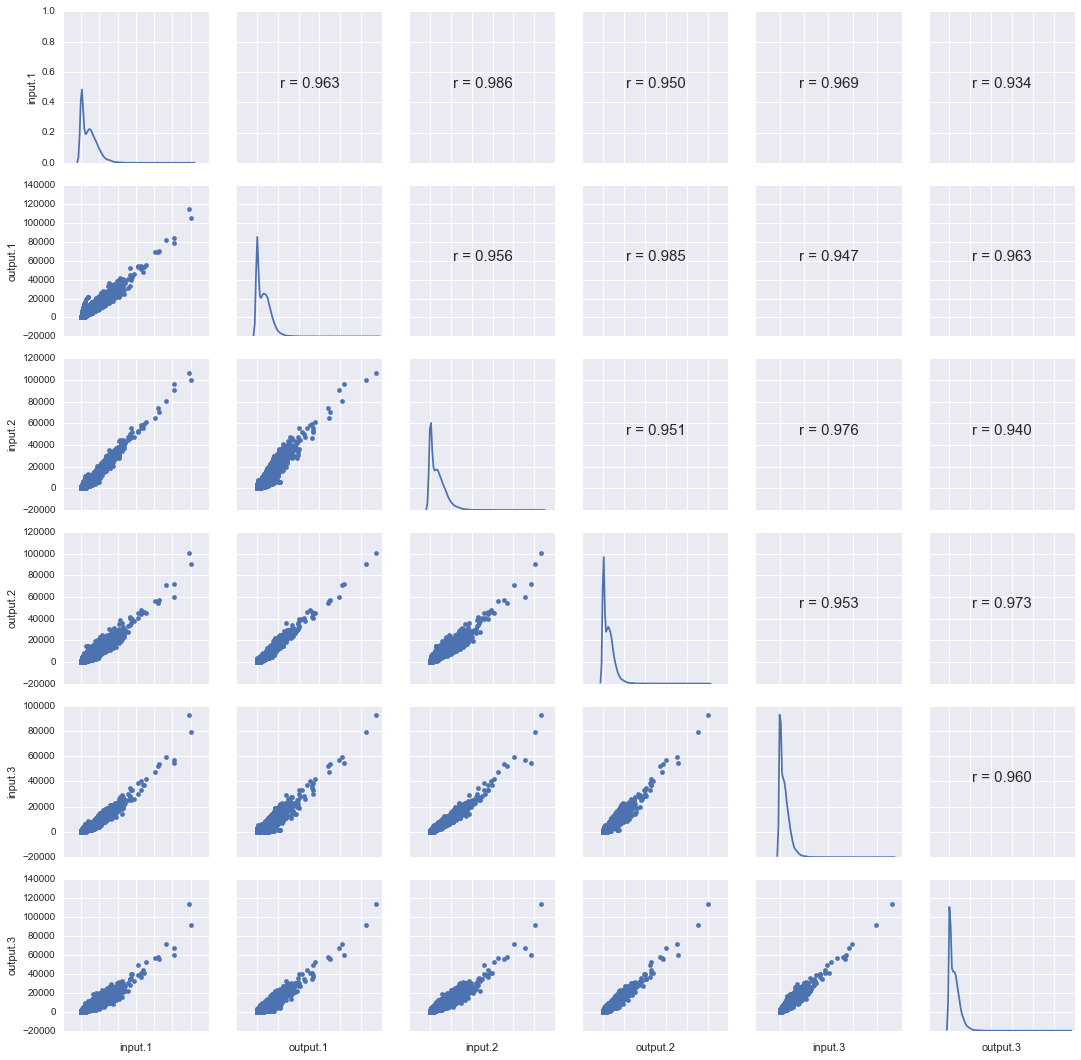

In [4]:
# plot control dataset correlation
tools.plot_correlation(control_raw);

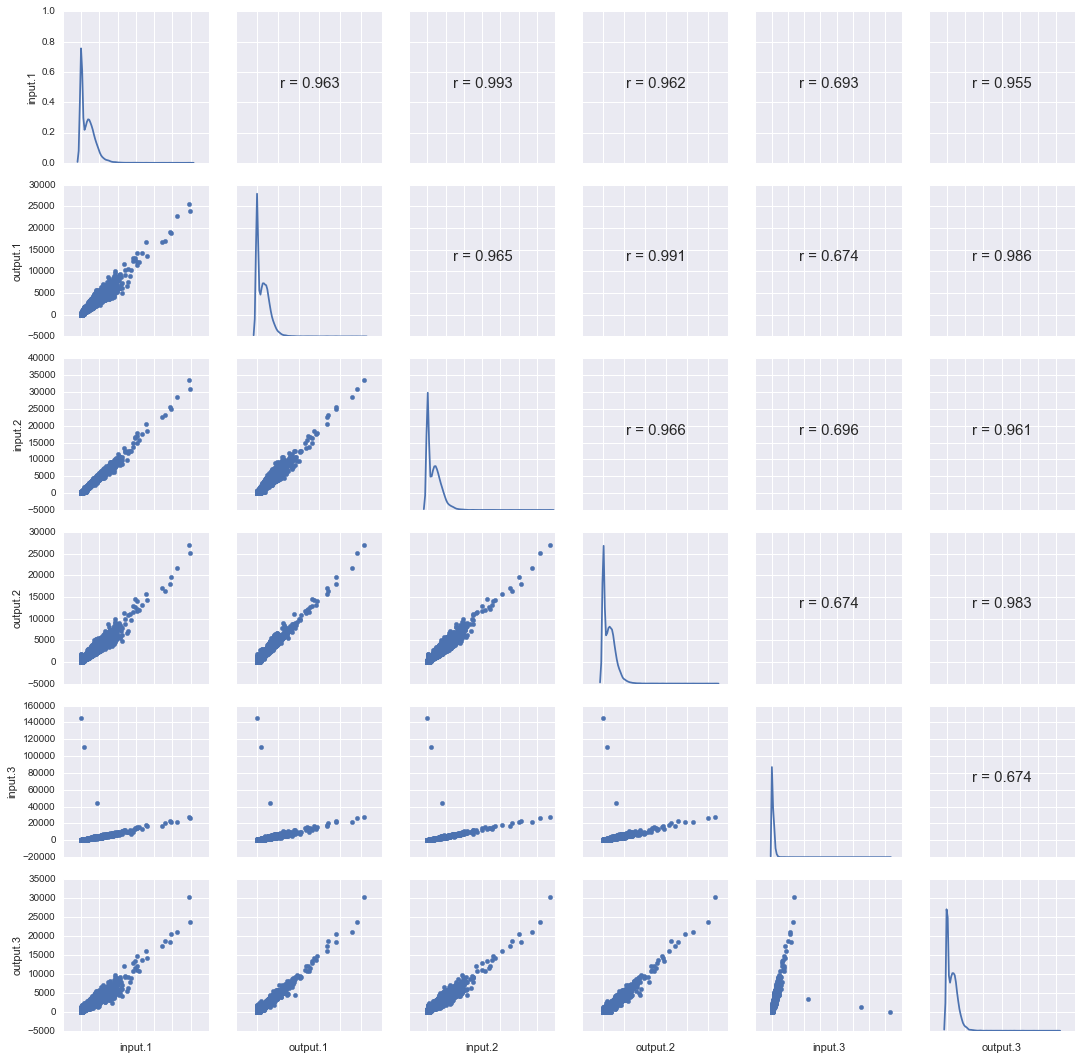

In [5]:
# plot control dataset correlation
tools.plot_correlation(treatment_raw);

These plots indicate:

* the intensities of the control arrays are systematically larger than the treatment arrays, suggesting that the effects of noise may be proportionally greater for the treatment arrays
* the control arrays are good candidates for quantile normalisation (QN; $r > 0.93$, with similar density distributions)
* the treatment array `input.3` dataset is potentially problematic for , due to three datapoints with intensities greater than 40,000 units having large leverage.

We can identify the troublesome probes

In [6]:
# Select outlying treatment input.3 values
treatment_raw.loc[treatment_raw['input.3'] > 4e4]

input.1    output.1      input.2     output.2    input.3  \
Systematic                                                                  
A_07_P000070  4251.70600  3054.75400  3997.707000  3013.079000   44857.48   
A_07_P061472    10.65405     4.49928     1.687277     3.855374  145625.60   
A_07_P052489   929.70990  1056.72400   987.524200   957.422400  110306.40   

                 output.3  
Systematic                 
A_07_P000070  3283.400000  
A_07_P061472     8.290274  
A_07_P052489  1327.634000

Without the influence of these three probes, the treatment datasets show good correlation, and strong similarity in distribution, so we are justified in using quantile normalisation.

In [7]:
# Pearson correlation coefficients for treatment data, excluding outliers
treatment_raw.loc[treatment_raw['input.3'] < 4e4].corr('pearson')

input.1  output.1   input.2  output.2   input.3  output.3
input.1   1.000000  0.962793  0.993381  0.961499  0.987666  0.954562
output.1  0.962793  1.000000  0.964688  0.990921  0.960784  0.986433
input.2   0.993381  0.964688  1.000000  0.966287  0.992854  0.961277
output.2  0.961499  0.990921  0.966287  1.000000  0.961224  0.982820
input.3   0.987666  0.960784  0.992854  0.961224  1.000000  0.960038
output.3  0.954562  0.986433  0.961277  0.982820  0.960038  1.000000

In [8]:
# Spearman correlation coefficients for treatment data, including outliers
treatment_raw.corr('spearman')

input.1  output.1   input.2  output.2   input.3  output.3
input.1   1.000000  0.974076  0.992560  0.967946  0.986361  0.959009
output.1  0.974076  1.000000  0.968833  0.985284  0.963805  0.972636
input.2   0.992560  0.968833  1.000000  0.969063  0.988809  0.955908
output.2  0.967946  0.985284  0.969063  1.000000  0.959092  0.968035
input.3   0.986361  0.963805  0.988809  0.959092  1.000000  0.961447
output.3  0.959009  0.972636  0.955908  0.968035  0.961447  1.000000

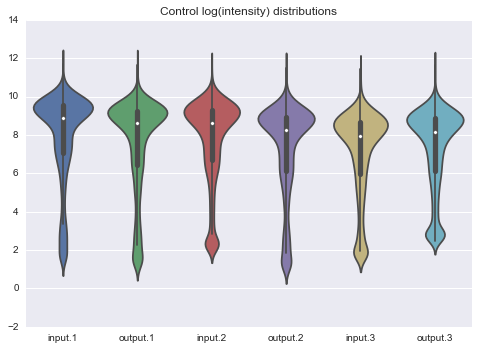

In [9]:
# Visualise control intensity distributions
g = sns.violinplot(log(control_raw))
g.set_title("Control log(intensity) distributions");

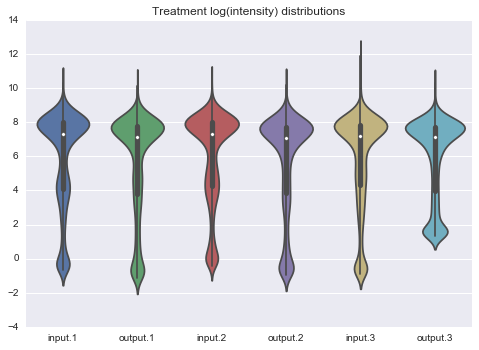

In [10]:
# Visualise treatment intensity distributions (with outliers)
g = sns.violinplot(log(treatment_raw))
g.set_title("Treatment log(intensity) distributions");

From these distributions it appears that treatment `output.3` appears to have a higher baseline signal than the other treatment arrays.

## Quantile normalisation

We have established that because the input and output arrays in both control and treatment conditions have strong correlation across all intensities and similar intensity distributions, we are justified in using quantile (mean) normalisation.

As we expect the overall effect on array signal to vary according to whether the sample was from the input (strong) or output (weak) set, and whether the sample came from the control or treatment pools, we divide the dataset into four components, and apply normalisation to four arrays independently, as subsets of the raw datasets `control_raw` and `treatment_raw`:

* `control_input`
* `control_output`
* `treatment_input`
* `treatment_output`

In [11]:
# Normalise inputs and outputs for control and treatment separately
control_input = tools.quantile_norm(control_raw, columns=['input.1', 'input.2', 'input.3'])
control_output = tools.quantile_norm(control_raw, columns=['output.1', 'output.2', 'output.3'])
treatment_input = tools.quantile_norm(treatment_raw, columns=['input.1', 'input.2', 'input.3'])
treatment_output = tools.quantile_norm(treatment_raw, columns=['output.1', 'output.2', 'output.3'])

We can visualise the effect this has on the distributions:

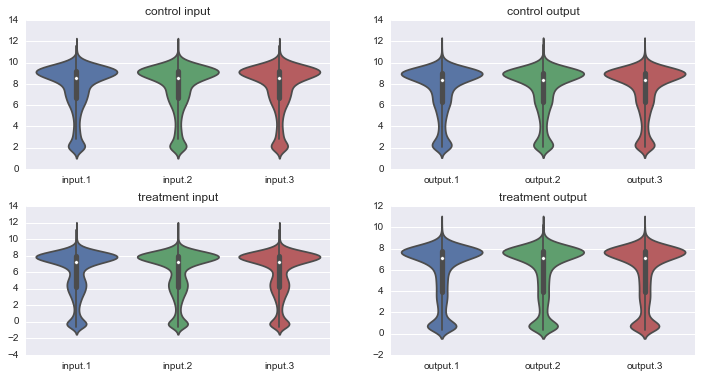

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
fig.subplots_adjust(hspace=.25)
axes = axes.ravel()
for ttl, arr, ax in zip(("control input", "control output", "treatment input", "treatment output"),
                        (control_input, control_output, treatment_input, treatment_output),
                        axes):
    ax.set_title(ttl)
    sns.violinplot(log(arr), ax=ax)

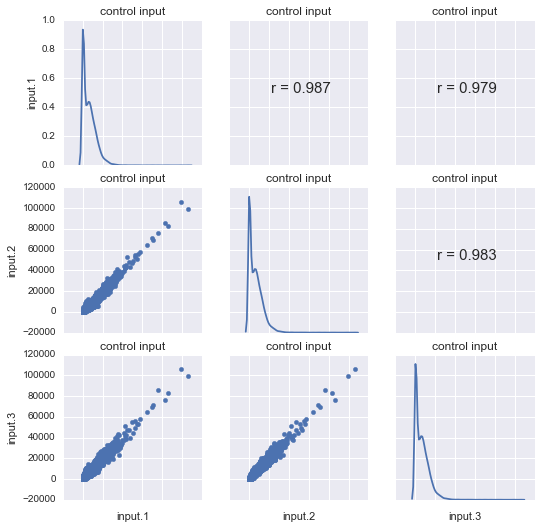

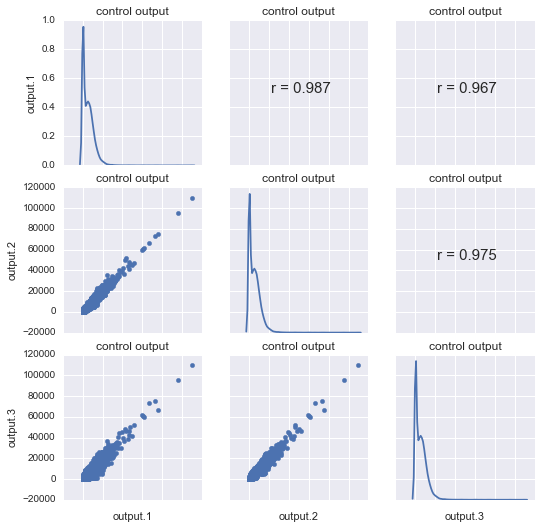

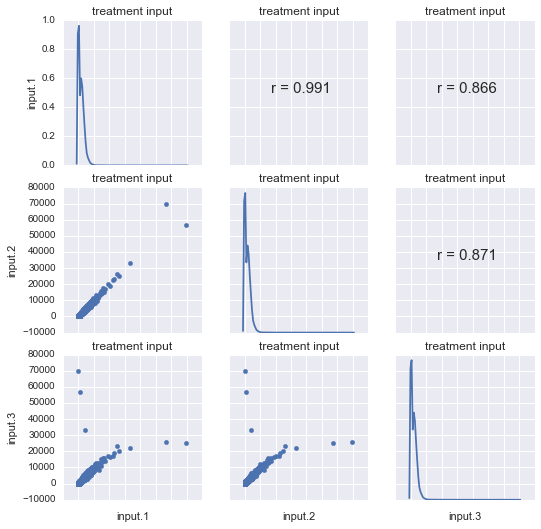

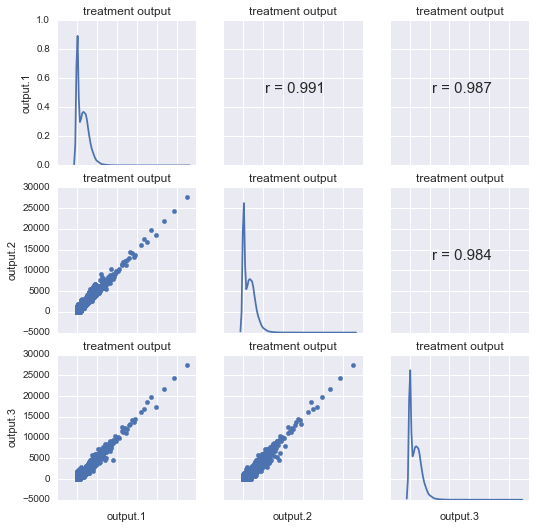

In [13]:
for ttl, arr in zip(("control input", "control output", "treatment input", "treatment output"),
                    (control_input, control_output, treatment_input, treatment_output)):
    tools.plot_correlation(arr, title=ttl)

## Collecting data

We now have four dataframes, each indexed by array probe systematic name, with three columns that correspond to replicates 1, 2, and 3 for either a control or a treatment run. For downstream analysis we want to organise this data as the following columns:

* `index`: unique ID
* `probe`: probe name (these apply across treatment/control and input/output)
* `input`: normalised input intensity value (for a particular probe and replicate)
* `output`: normalised input intensity value (for a particular probe and replicate)
* `treatment`: 0/1 indicating whether the measurement was made for the control or treatment sample
* `replicate`: 1, 2, 3 indicating which replicate the measurement was made from

We can have other columns too, but for downstream analysis we want the above columns

### Wide to long form

First, we convert our data frames from wide (e.g. `input.1`, `input.2`, `input.3` columns) to long (e.g. `probe`, `input`, `output`, `replicate`) form - once for the control data, and once for the treatment data. We match on a multi-index of probe and replicate.

In [14]:
# Convert control and treatment data to long format
control_long = tools.wide_to_long_join(control_input, control_output, treatment=False)
treatment_long = tools.wide_to_long_join(treatment_input, treatment_output, treatment=True)

Then we combine them into a single, long-form dataset:

In [15]:
control_long.head()

probe  replicate      input     output  treatment
0  A_07_P010355          1  10.049401   5.969886          0
1  A_07_P039196          1   7.638637   7.230899          0
2  A_07_P039195          1  14.394261  15.832703          0
3  A_07_P039186          1   7.872936  18.637283          0
4  A_07_P039181          1  10.100042   7.566543          0

In [16]:
# Combine dataframes
data = control_long.append(treatment_long, ignore_index=True)
data['log_input'] = log(data['input'])
data['log_output'] = log(data['output'])

This makes it easier to gather up groups of data by their labelled properties, as in the violin plot below:

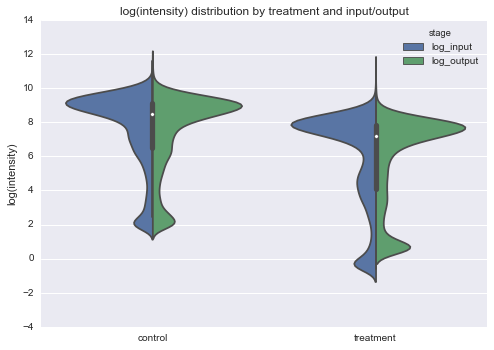

In [17]:
# Visualise input v output distributions
tools.plot_input_output_violin(data)

## Sakai and DH10B data

We are interested mostly in the potential for differential representation of *E.coli* Sakai protein products, and could later remove all probes that are not expected to hybridise to *E. coli* Sakai from the dataset. We are not concerned with high-level interactions with *E. coli* DH10B genes, and may be willing later on to exclude these from the analysis or, at any rate, interpret our results by splitting output on the basis of likely hybridisation origin.

Evidence for potential hybridisation to Sakai was determined by default `BLASTN` query of each probe sequence against chromosome and plasmid feature nucleotide sequences from the NCBI records:

* `GCF_000019425.1_ASM1942v1_cds_from_genomic.fna`
* `GCF_000008865.1_ASM886v1_cds_from_genomic.fna`

using the commands:

```
$ blastn -query Array/probe_seqlist.fas -subject Sakai/GCF_000008865.1_ASM886v1_cds_from_genomic.fna -outfmt 6 -out probes_blastn_sakai.tab -perc_identity 100
$ blastn -query Array/probe_seqlist.fas -subject DH10B/GCF_000019425.1_ASM1942v1_cds_from_genomic.fna -outfmt 6 -out probes_blastn_dh10b.tab -perc_identity 100
```

We read the data from the output files, and add new columns: `dh10b_match` and `sakai_match`, which take values of `1` if the probe matches a feature from the corresponding genome, and `NaN` otherwise; `match` which reports the BLASTN match made by the probe (**NOTE: this only records one match, though several may be made**); and `locus_tag`, which reports the locus tag corresponding to the recorded BLASTN hit in `match`.

In [18]:
sakai_hits = tools.subset_blast(data, "data/probes_blastn_sakai.tab",
                                'data/Sakai/GCF_000008865.1_ASM886v1_cds_from_genomic.fna',
                                'sakai')

In [19]:
dh10b_hits = tools.subset_blast(data, "data/probes_blastn_dh10b.tab",
                                'data/DH10B/GCF_000019425.1_ASM1942v1_cds_from_genomic.fna',
                                'dh10b')

We will certainly be interested in probes that hybridise to Sakai, and likely those that hybridise to DH10B. The [array was however designed to report on several *E. coli* isolates](http://www.ebi.ac.uk/arrayexpress/arrays/A-GEOD-13359/?ref=E-GEOD-46455), and not all probes should be expected to hybridise, so we could consider the non-hybridising probes not to be of interest, and censor those probes:

In [20]:
# remove non-BLASTN match probes
censored_data = sakai_hits.append(dh10b_hits)
censored_data = censored_data.fillna(0)
print(censored_data.shape)
censored_data.head()

(71808, 11)


dh10b_match       input locus_tag  log_input  log_output  \
0          0.0   13.354233   ECs1176   2.591833    2.352119   
1          0.0    6.815142   ECs1176   1.919147    2.431403   
2          0.0  146.893973   ECs1176   4.989711    2.125809   
3          0.0    0.629964   ECs1176  -0.462092    0.878914   
4          0.0    0.651612   ECs1176  -0.428306    1.853818   

                                  match     output         probe  replicate  \
0  lcl|NC_002695.1_cds_NP_309203.1_1134  10.507812  A_07_P052986          1   
1  lcl|NC_002695.1_cds_NP_309203.1_1134  11.374824  A_07_P052986          2   
2  lcl|NC_002695.1_cds_NP_309203.1_1134   8.379672  A_07_P052986          3   
3  lcl|NC_002695.1_cds_NP_309203.1_1134   2.408282  A_07_P052986          1   
4  lcl|NC_002695.1_cds_NP_309203.1_1134   6.384148  A_07_P052986          2   

   sakai_match  treatment  
0            1          0  
1            1          0  
2            1          0  
3            1          1  
4            1          1

In [21]:
censored_data.describe()

dh10b_match          input     log_input    log_output         output  \
count  71808.000000   71808.000000  71808.000000  71808.000000   71808.000000   
mean       0.419619    5749.261610      7.635319      7.408407    4746.473870   
std        0.493500    7889.719475      1.997829      2.069902    6730.933397   
min        0.000000       0.534424     -0.626565      0.377605       1.458786   
25%        0.000000    1219.361833      7.106083      6.924316    1016.698833   
50%        0.000000    3247.301333      8.085580      7.886295    2660.567667   
75%        1.000000    7788.689667      8.960428      8.789396    6564.263667   
max        1.000000  106324.406667     11.574250     11.604565  109596.966667   

          replicate   sakai_match     treatment  
count  71808.000000  71808.000000  71808.000000  
mean       2.000000      0.802891      0.500000  
std        0.816502      0.397818      0.500003  
min        1.000000      0.000000      0.000000  
25%        1.000000      1.000000      0.000000  
50%        2.000000      1.000000      0.500000  
75%        3.000000      1.000000      1.000000  
max        3.000000      1.000000      1.000000

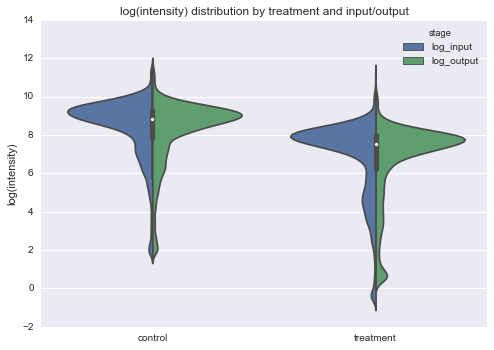

In [22]:
# Visually inspect the effect of censoring on distribution
tools.plot_input_output_violin(censored_data)

## Write data

We write the censored, normalised, long-format data to `output/normalised_array_data.tab`.

In [23]:
# Write data to file
os.makedirs("output", exist_ok=True)
censored_data.to_csv("output/normalised_array_data.tab", sep="\t", index=False)

Later we will also want to assign an index for common probe ID and locus tag to each probe, and we can do that here, writing out the indexed data:

In [24]:
# create indices and values for probes
probe_ids = censored_data['probe'].unique()
nprobes = len(probe_ids)
probe_lookup = dict(zip(probe_ids, range(nprobes)))

# add data column with probe index from probe_lookup
censored_data['probe_index'] = censored_data['probe'].replace(probe_lookup).values

# create indices and values for probes
locus_tags = censored_data['locus_tag'].unique()
ntags = len(locus_tags)
tag_lookup = dict(zip(locus_tags, range(ntags)))

# add data column with probe index from probe_lookup
censored_data['locus_index'] = censored_data['locus_tag'].replace(tag_lookup).values

# write indexed data to file for later use
censored_data.to_csv("output/normalised_indexed_array_data.tab", sep="\t", index=False)

For testing, we will work with a small subset of the data to develop the models/code without excessive compute time. For this we subset 200 probe IDs - but this means we need to reindex the probes.

In [25]:
# Make reduced set of locus tags for testing
random.seed(tools.SEED)  # for reproducibility of random choice
tag_indices = [random.randint(0, ntags) for i in range(2000)]  # 2000 random locus_tag indices
reduced = censored_data.loc[censored_data['locus_index'].isin(tag_indices)]

# create indices and values for probes
tag_ids = reduced['locus_tag'].unique()
ntags = len(tag_ids)
tag_lookup = dict(zip(tag_ids, range(ntags)))

# add data column with probe index from probe_lookup
reduced['locus_index'] = reduced['locus_tag'].replace(tag_lookup).values

# write test data
reduced.to_csv("output/reduced_normalised_locus_indexed_array_data.tab",
               sep="\t", index=False)

In [26]:
# Make reduced set of probe IDs for testing
random.seed(tools.SEED)  # for reproducibility of random choice
probe_indices = [random.randint(0, nprobes) for i in range(2000)]  # 2000 random probe indices
reduced = censored_data.loc[censored_data['probe_index'].isin(probe_indices)]

# create indices and values for probes
probe_ids = reduced['probe'].unique()
nprobes = len(probe_ids)
probe_lookup = dict(zip(probe_ids, range(nprobes)))

# add data column with probe index from probe_lookup
reduced['probe_index'] = reduced['probe'].replace(probe_lookup).values

# write test data
reduced.to_csv("output/reduced_normalised_probe_indexed_array_data.tab",
               sep="\t", index=False)

In [27]:
reduced.head()

dh10b_match       input locus_tag  log_input  log_output  \
0          0.0   13.354233   ECs1176   2.591833    2.352119   
1          0.0    6.815142   ECs1176   1.919147    2.431403   
2          0.0  146.893973   ECs1176   4.989711    2.125809   
3          0.0    0.629964   ECs1176  -0.462092    0.878914   
4          0.0    0.651612   ECs1176  -0.428306    1.853818   

                                  match     output         probe  replicate  \
0  lcl|NC_002695.1_cds_NP_309203.1_1134  10.507812  A_07_P052986          1   
1  lcl|NC_002695.1_cds_NP_309203.1_1134  11.374824  A_07_P052986          2   
2  lcl|NC_002695.1_cds_NP_309203.1_1134   8.379672  A_07_P052986          3   
3  lcl|NC_002695.1_cds_NP_309203.1_1134   2.408282  A_07_P052986          1   
4  lcl|NC_002695.1_cds_NP_309203.1_1134   6.384148  A_07_P052986          2   

   sakai_match  treatment  probe_index  locus_index  
0            1          0            0            0  
1            1          0            0            0  
2            1          0            0            0  
3            1          1            0            0  
4            1          1            0            0